# **Fine-Grained Sentiment Analysis (3 classes) E-Commerce Reviews**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#file_path = "/content/drive/MyDrive/Yelp Reviews.csv"
#df = pd.read_csv(file_path, encoding='ISO-8859-1')
#df = df[['Text', 'Sentiment']].dropna()
#df.head()

# Path to your dataset on the server
file_path = "/home/arafatmdeasin/usman/project/dataset/E-Commerce Reviews (5 Classes).csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

,Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,Positive
1,Love this dress! it's sooo pretty. i happene...,Very Positive
2,I had such high hopes for this dress and reall...,Neutral
3,"I love, love, love this jumpsuit. it's fun, fl...",Very Positive
4,This shirt is very flattering to all due to th...,Very Positive


In [4]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 22641
Number of instances per sentiment:
Sentiment
Very Positive    12540
Positive          4908
Neutral           2823
Negative          1549
Very Negative      821
Name: count, dtype: int64


In [5]:
sentiment_mapping = {
    'Very Positive': 'Positive',
    'Positive': 'Positive',
    'Neutral': 'Neutral',
    'Negative': 'Negative',
    'Very Negative': 'Negative'
}

df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

total_instances = len(df)
sentiment_counts = df['Sentiment'].value_counts()

print(f"Total instances: {total_instances}\n")
print("Number of instances per new sentiment:")
print(sentiment_counts)


Total instances: 22641

Number of instances per new sentiment:
Sentiment
Positive    17448
Neutral      2823
Negative     2370
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

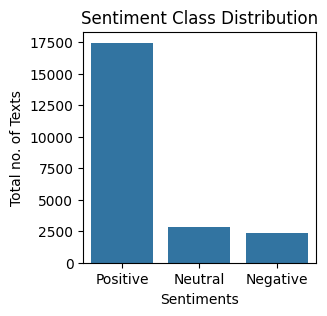

In [6]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [7]:

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

# sentiment_to_label = {
#     "Very Negative": 0,
#     "Negative": 1,
#     "Neutral": 2,
#     "Positive": 3,
#     "Very Positive": 4
# }

# df['label'] = df['Sentiment'].map(sentiment_to_label)

# print("Label Mapping:")
# for sentiment, label in sentiment_to_label.items():
#     print(f"{sentiment} → {label}")


Label Mapping:
Negative: 0
Neutral: 1
Positive: 2


### Step 5: Train-Test Split

In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 18112, Val size: 2264, Test size: 2265


### Step 6: Tokenization

In [9]:
base_model_name = "roberta-base"
finetuned_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


### Step 7: Dataset Class

In [11]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100
    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
            "accuracy": acc,
            "precision": prec * 100,
            "recall": rec * 100,
            "f1_macro": f1 * 100,
            "similarity_score": similarity_score,
            "confidence_score": confidence_score,
    }


### Step 9: Evaluate Without Fine-Tuning

In [36]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1_macro",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



===== Performance of Pretrained Transformer Model =====

accuracy is: 78.81%
precision is: 52.61%
recall is: 57.28%
f1_macro is: 53.09%
similarity_score is: 82.80%
confidence_score is: 85.25%

===== Evaluation Details =====
Eval Loss: 0.5319
Runtime: 2.7428 sec
Samples per second: 825.792


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

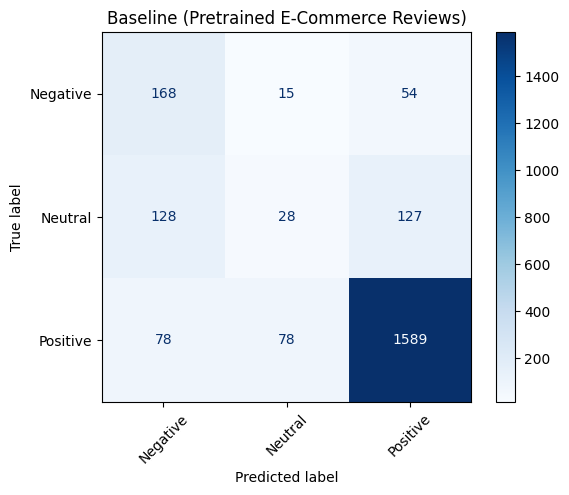

In [27]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = [ "Negative", "Neutral", "Positive"]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues", xticks_rotation=45
)
plt.title("Baseline (Pretrained E-Commerce Reviews)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [16]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=3,
    hidden_dropout_prob=0.5,           
    attention_probs_dropout_prob=0.4, 
    classifier_dropout=0.5              
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,         
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",       
    save_strategy="epoch",
    learning_rate=3e-5,           
    weight_decay=0.05,             
    warmup_ratio=0.06,        
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  
    greater_is_better=True,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2,    
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    seed=42,
    dataloader_pin_memory=True,
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  
)

trainer_base.train()


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/acc

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,Similarity Score,Confidence Score
1,0.772400,0.793781,77.075972,25.691991,33.333333,29.018043,78.031097,91.158401
2,0.722300,0.753795,77.075972,25.691991,33.333333,29.018043,78.212464,89.097336
3,0.662900,0.498516,79.770318,76.809606,48.939952,46.216450,83.669336,80.919731
4,0.552300,0.497418,80.035336,57.627210,44.531174,45.997215,84.521376,84.191414
5,0.507600,0.536645,81.227915,58.733124,51.494343,52.955647,84.703712,88.090500
6,0.500800,0.526791,81.316254,59.971687,51.100582,52.968449,84.702123,88.202385


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


TrainOutput(global_step=3396, training_loss=0.6197289780256183, metrics={'train_runtime': 514.747, 'train_samples_per_second': 211.117, 'train_steps_per_second': 6.597, 'total_flos': 8432719259827968.0, 'train_loss': 0.6197289780256183, 'epoch': 6.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [39]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1_macro",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

accuracy is: 81.77%
precision is: 63.15%
recall is: 51.76%
f1_macro is: 54.61%
similarity_score is: 84.77%
confidence_score is: 88.07%

===== Evaluation Details =====
Eval Loss: 0.5362
Runtime: 2.8269 sec
Samples per second: 801.22


#### Step 10.2: Confusion Matrix Analysis

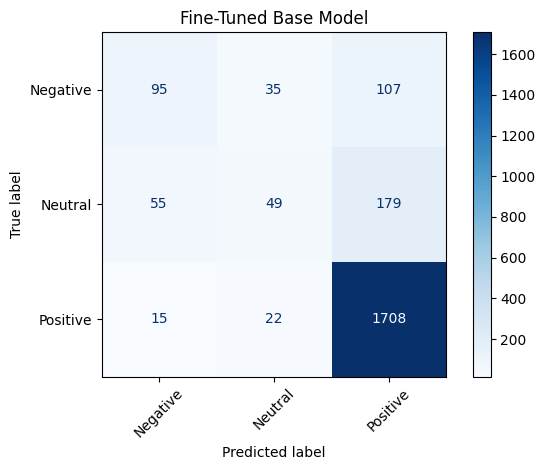

In [40]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = ["Negative", "Neutral", "Positive"]

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

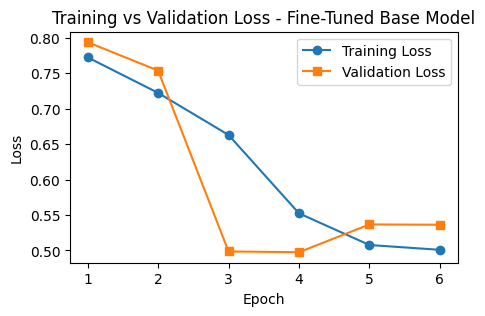

In [41]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [42]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.4,
    target_modules=["query", "key", "value", "output.dense"],
    bias="none",
    modules_to_save=["classifier"]
)

adapter_model = get_peft_model(adapter_model, peft_config)
adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.05,
    warmup_ratio=0.05,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    max_grad_norm=1.0,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=True,
    remove_unused_columns=True
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_adapter.train()
adapter_metrics = trainer_adapter.evaluate(test_dataset)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 1,551,363 || all params: 126,199,302 || trainable%: 1.2293


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,Similarity Score,Confidence Score
1,0.714100,0.624430,77.075972,25.691991,33.333333,29.018043,79.971454,80.528297
2,0.579200,0.523850,77.340989,54.354525,34.177215,30.715409,82.568408,80.093163
3,0.529400,0.474993,79.858657,66.378144,42.996228,44.869915,84.514887,78.145027
4,0.504500,0.454142,81.007067,60.843616,48.169591,48.222662,85.422747,77.895302
5,0.492800,0.446166,80.565371,66.796739,45.584980,48.626189,85.118775,80.719307
6,0.485800,0.441387,80.697880,66.819966,45.804928,49.216068,85.256249,80.790031
7,0.483100,0.437417,81.360424,67.968622,48.400811,51.970799,85.560858,80.044777
8,0.481300,0.437453,81.272085,67.550622,48.119517,51.650122,85.526730,80.218254


/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/arafatmdeasin/usman/.ve_torch/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current defa

#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [43]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1_macro",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

accuracy is: 81.59%
precision is: 69.38%
recall is: 48.55%
f1_macro is: 52.00%
similarity_score is: 85.56%
confidence_score is: 80.14%

===== Evaluation Details =====
Eval Loss: 0.4394
Runtime: 3.649 sec
Samples per second: 620.71


#### Step 11.2: Confusion Matrix Analysis

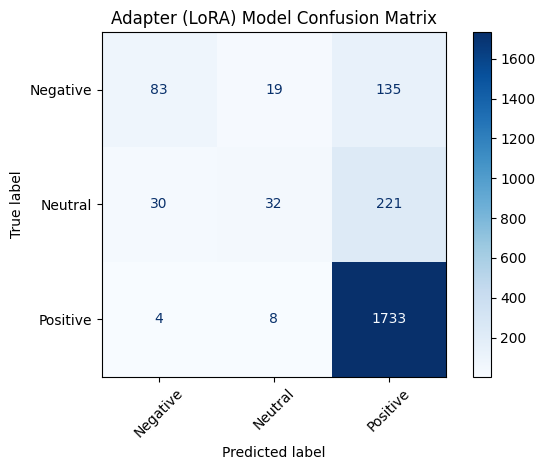

In [44]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = ["Negative", "Neutral", "Positive"]
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

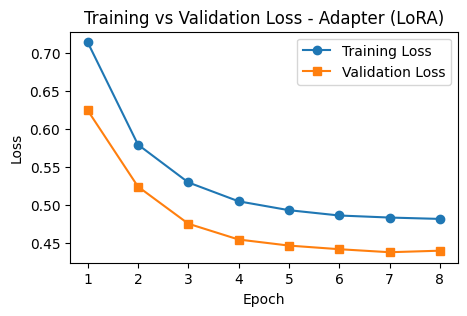

In [45]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

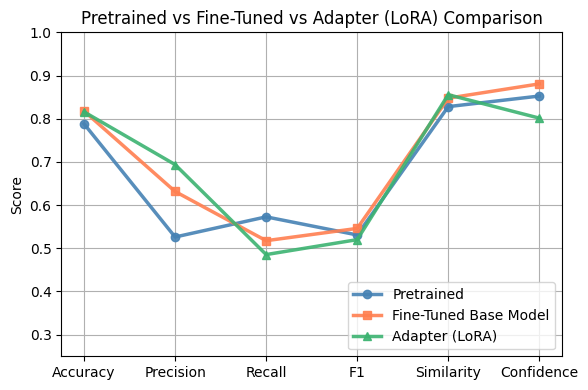

In [46]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]
metric_keys = ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]

def get_metric(metrics_dict, key):
    for variant in [f"eval_{key}", key, f"{key}_macro", f"eval_{key}_macro"]:
        if variant in metrics_dict:
            return metrics_dict[variant]
    return 0.0

pretrained_vals = np.array([get_metric(baseline_metrics, k) for k in metric_keys]) / 100
base_vals       = np.array([get_metric(finetuned_metrics, k) for k in metric_keys]) / 100
adapter_vals    = np.array([get_metric(adapter_metrics, k) for k in metric_keys]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))
plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.25, 1.00)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


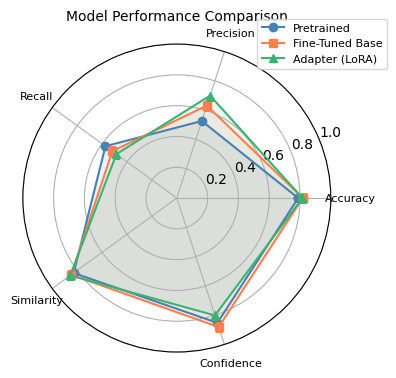

In [47]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Accuracy", "Precision", "Recall", "Similarity", "Confidence"]

baseline_vals = np.array([78.81, 52.61, 57.28, 82.80, 85.25]) / 100
finetuned_vals = np.array([81.77, 63.15, 51.76, 84.77, 88.07]) / 100
adapter_vals = np.array([81.59, 69.94, 48.52, 85.55, 80.13]) / 100

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

baseline_vals = np.concatenate([baseline_vals, [baseline_vals[0]]])
finetuned_vals = np.concatenate([finetuned_vals, [finetuned_vals[0]]])
adapter_vals = np.concatenate([adapter_vals, [adapter_vals[0]]])

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

ax.plot(angles, baseline_vals, marker='o', linestyle='-', linewidth=1.5, label="Pretrained", color='steelblue')
ax.fill(angles, baseline_vals, color='steelblue', alpha=0.1)

ax.plot(angles, finetuned_vals, marker='s', linestyle='-', linewidth=1.5, label="Fine-Tuned Base", color='coral')
ax.fill(angles, finetuned_vals, color='coral', alpha=0.1)

ax.plot(angles, adapter_vals, marker='^', linestyle='-', linewidth=1.5, label="Adapter (LoRA)", color='mediumseagreen')
ax.fill(angles, adapter_vals, color='mediumseagreen', alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=8)
ax.set_ylim(0, 1)
plt.title("Model Performance Comparison", size=10, y=1.05)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=8)
plt.show()
